# Lista 03

Artificial neural networks for image classification.

In [1]:
READ_DATASETS = False

## Common Functions

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Plotting

In [3]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

In [4]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

In [5]:
def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[0]
    color2 = colors[1]
    if values2 is None:
        width = 0.8
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0) #, fontdict={'fontsize':9})
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

### Model History

In [64]:
def plot_metrics(history, metrics = ['acc', 'loss']):
    best = np.argmax(history['val_acc'])
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            range(len(history[metric])),
            history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            range(len(history[metric])),
            history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.plot(best,
                 history['val_'+metric][best],
                 marker='o',
                 color='red')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()

### Confusion Matrix

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [144]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")

In [145]:
def model_summary(X_test, y_test, y_pred, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Accuracy", "Recall")]
        acc = accuracy_score(y_test, y_pred)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        results.append((
            "All",
            f"{acc:0.4f}",
            f"{balanced_accuracy:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        for i, (label, rec) in enumerate(zip(labels, recall)):
            acc = accuracy_score(y_test[y_test==i], y_pred[y_test==i])
            results.append((
                label,
                f"{acc:0.4f}",
                f"{rec:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=25)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()

    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Database

 https://medmnist.com/

In [9]:
from medmnist import BloodMNIST

image_size=28
if READ_DATASETS:
    train_dataset = BloodMNIST(split="train", download=True, size=image_size)
    val_dataset = BloodMNIST(split="val", download=True, size=image_size)
    test_dataset = BloodMNIST(split="test", download=True, size=image_size)

    _ = joblib.dump(train_dataset, f"data/train_dataset_{image_size}.sav")
    _ = joblib.dump(val_dataset, f"data/val_dataset_{image_size}.sav")
    _ = joblib.dump(test_dataset, f"data/test_dataset_{image_size}.sav")
else:
    train_dataset = joblib.load(f"data/train_dataset_{image_size}.sav")
    val_dataset = joblib.load(f"data/val_dataset_{image_size}.sav")
    test_dataset = joblib.load(f"data/test_dataset_{image_size}.sav")

In [10]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [11]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [12]:
X_train = train_dataset.imgs[:] / 255.
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:] / 255.
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:] / 255.
y_test = test_dataset.labels[:,0]

In [13]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


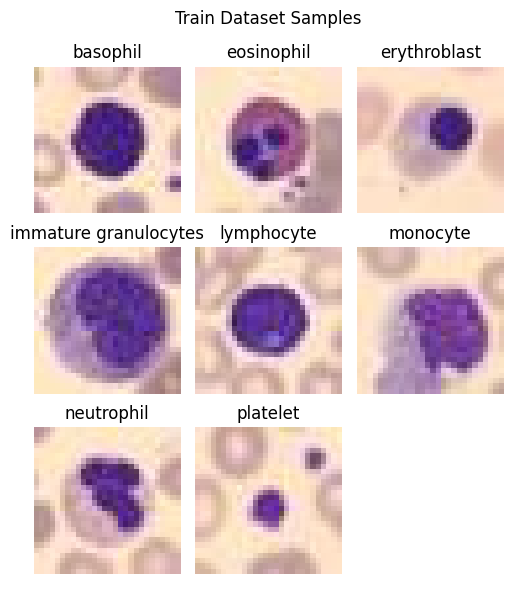

In [14]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Dataset Samples")
plt.show(image_panel)

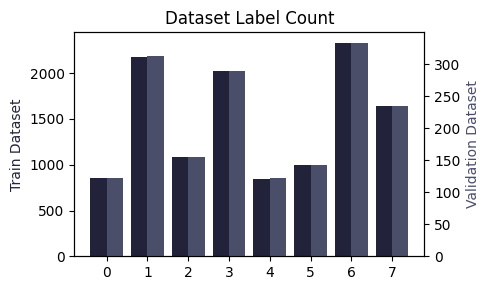

In [15]:
label_count_train = [sum(y_train==i) for i in range(len(labels))]
label_count_val = [sum(y_val==i) for i in range(len(labels))]
create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset",
    values2=label_count_val,
    axis2_label="Validation Dataset",
    title="Dataset Label Count",
)
plt.show()

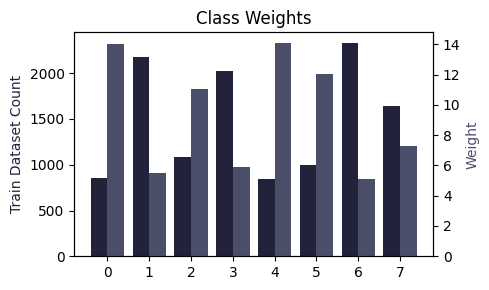

In [16]:
class_weight = {i:1 / sum(y_train==i) * len(y_train) for i in range(len(labels))}

create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset Count",
    values2=class_weight.values(),
    axis2_label="Weight",
    title="Class Weights",
)
plt.show()

## MLP

In [17]:
RERUN_MLP = False

In [110]:
# import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


In [104]:
def make_mlp(neurons=100, optimizer="rmsprop", activation="relu", use_augmentation=False):

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(image_size,image_size,3)))

    if use_augmentation:
        model.add(keras.layers.RandomFlip("horizontal_and_vertical"))
        model.add(keras.layers.RandomRotation(0.2))

    model.add(keras.layers.Flatten(name="Flatten"))
    model.add(keras.layers.Dense(neurons, activation=activation, name="Dense"))
    model.add(keras.layers.Dense(len(labels), activation="softmax", name="Output"))

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        # optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

In [96]:
def save_model(name, model):
    _ = joblib.dump(model, f"models/{name}.sav")

def load_model(name):
    model = joblib.load(f"models/{name}.hist")
    return model

In [83]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=3,
        start_from_epoch=5,
        mode='max',
        restore_best_weights=True
    ),
]

In [118]:
[2**i for i in range(4,8)]

[16, 32, 64, 128]

https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://pypi.org/project/scikeras/0.1.8/

In [121]:
params_mlp = {
    'neurons': [2**i for i in range(6,11)],
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    'use_augmentation': [False, True],
    'batch_size': [2**i for i in range(4,8)],
}

In [128]:
mlp_classf = KerasClassifier(model=make_mlp,
                             callbacks=callbacks,
                             batch_size=32,
                             use_augmentation=False,
                             neurons=128,
                             optimizer="adam",
                             activation="relu")

In [129]:
mlp_rnd_search = RandomizedSearchCV(mlp_classf,params_mlp, cv=3)

In [130]:
mlp_rnd_search_results = mlp_rnd_search.fit(X_train, y_train, epochs=50,
                                            validation_data=(X_val, y_val),
                                            callbacks=callbacks)

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - acc: 0.2770 - loss: 2.0628 - val_acc: 0.3797 - val_loss: 1.4543
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4527 - loss: 1.3812 - val_acc: 0.5870 - val_loss: 1.1799
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.5340 - loss: 1.2056 - val_acc: 0.5018 - val_loss: 1.3129
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.5738 - loss: 1.1199 - val_acc: 0.6203 - val_loss: 0.9739
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.6095 - loss: 1.0457 - val_acc: 0.6314 - val_loss: 0.9546
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.6303 - loss: 0.9847 - val_acc: 0.6665 - val_loss: 0.8921
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc: 0.6148 - loss: 1.0000 - val_acc: 0.5929 - val_loss: 1.0219
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.6449 - loss: 0.9376 - val_acc: 0.5794 - val_loss: 1.0630
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc: 0.2802 - loss: 2.1841 - val_acc: 0.3843 - val_loss: 1.5112
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc: 0.4765 - loss: 1.3656 - val_acc: 0.3791 - val_loss: 1.4888
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.5401 - loss: 1.2052 - val_acc: 0.6022 - val_loss: 1.0620
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.5755 - loss: 1.1192 - val_acc: 0.6186 - val_loss: 1.0050
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.6146 - loss: 1.0557 - val_acc: 0.5911 - val_loss: 1.0930
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.6163 - loss: 1.0265 - val_acc: 0.6116 - val_loss: 0.9550
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6388 - loss: 0.9467 - val_acc: 0.7249 - val_loss: 0.8320
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.6556 - loss: 0.9318 - val_acc: 0.7079 - val_loss: 0.8031
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/5

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.2908 - loss: 1.9986 - val_acc: 0.5093 - val_loss: 1.3879
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.4675 - loss: 1.3702 - val_acc: 0.4936 - val_loss: 1.3452
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.5346 - loss: 1.2202 - val_acc: 0.5257 - val_loss: 1.0679
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.5600 - loss: 1.1383 - val_acc: 0.5409 - val_loss: 1.1002
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.5819 - loss: 1.0843 - val_acc: 0.5946 - val_loss: 1.0198
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.6188 - loss: 1.0283 - val_acc: 0.5415 - val_loss: 1.1098
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6361 - loss: 0.9795 - val_acc: 0.6618 - val_loss: 0.8983
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6440 - loss: 0.9572 - val_acc: 0.6051 - val_loss: 1.0315
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - acc: 0.3398 - loss: 1.8168 - val_acc: 0.4836 - val_loss: 1.2222
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - acc: 0.5769 - loss: 1.1043 - val_acc: 0.3481 - val_loss: 1.4792
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6244 - loss: 0.9876 - val_acc: 0.5461 - val_loss: 1.2600
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.6692 - loss: 0.8957 - val_acc: 0.6244 - val_loss: 0.9677
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6737 - loss: 0.8767 - val_acc: 0.3954 - val_loss: 1.7173
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - acc: 0.6816 - loss: 0.8455 - val_acc: 0.5199 - val_loss: 1.2550
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7025 - loss: 0.8030 - val_acc: 0.6793 - val_loss: 0.9072
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.7132 - loss: 0.7762 - val_acc: 0.7827 - val_loss: 0.6334
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15m

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.3472 - loss: 1.9195 - val_acc: 0.4188 - val_loss: 1.4456
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.5641 - loss: 1.1372 - val_acc: 0.5970 - val_loss: 1.1274
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.6231 - loss: 0.9927 - val_acc: 0.6028 - val_loss: 0.9727
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.6623 - loss: 0.9289 - val_acc: 0.5946 - val_loss: 1.0942
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6811 - loss: 0.8809 - val_acc: 0.5169 - val_loss: 1.2311
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6821 - loss: 0.8608 - val_acc: 0.7091 - val_loss: 0.7627
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7093 - loss: 0.8041 - val_acc: 0.6630 - val_loss: 0.8887
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.7162 - loss: 0.7623 - val_acc: 0.5654 - val_loss: 1.2957
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.3370 - loss: 1.8782 - val_acc: 0.3440 - val_loss: 1.9471
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.5515 - loss: 1.1545 - val_acc: 0.5140 - val_loss: 1.1736
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.6175 - loss: 1.0244 - val_acc: 0.5391 - val_loss: 1.2041
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6518 - loss: 0.9487 - val_acc: 0.6086 - val_loss: 1.0392
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6695 - loss: 0.8896 - val_acc: 0.7120 - val_loss: 0.7713
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6827 - loss: 0.8567 - val_acc: 0.5123 - val_loss: 1.4478
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.6982 - loss: 0.8271 - val_acc: 0.5724 - val_loss: 1.0914
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.7150 - loss: 0.7956 - val_acc: 0.6367 - val_loss: 1.0036
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.2378 - loss: 2.5057 - val_acc: 0.3732 - val_loss: 1.5329
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.3863 - loss: 1.5257 - val_acc: 0.2979 - val_loss: 1.7419
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.4183 - loss: 1.4320 - val_acc: 0.5508 - val_loss: 1.2528
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5056 - loss: 1.3012 - val_acc: 0.5134 - val_loss: 1.3796
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5255 - loss: 1.2297 - val_acc: 0.4936 - val_loss: 1.1974
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5448 - loss: 1.1856 - val_acc: 0.4708 - val_loss: 1.3251
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5645 - loss: 1.1259 - val_acc: 0.6431 - val_loss: 1.0373
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5938 - loss: 1.0666 - val_acc: 0.4831 - val_loss: 1.1934
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.2261 - loss: 2.3906 - val_acc: 0.3289 - val_loss: 1.7397
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3814 - loss: 1.5523 - val_acc: 0.4772 - val_loss: 1.3785
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.4658 - loss: 1.3860 - val_acc: 0.3943 - val_loss: 1.4496
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.4955 - loss: 1.3073 - val_acc: 0.4644 - val_loss: 1.2255
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5119 - loss: 1.2560 - val_acc: 0.4597 - val_loss: 1.4665
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5566 - loss: 1.1876 - val_acc: 0.5181 - val_loss: 1.2164
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.5572 - loss: 1.1507 - val_acc: 0.6057 - val_loss: 1.0583
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5908 - loss: 1.0744 - val_acc: 0.4480 - val_loss: 1.3798
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.2139 - loss: 2.3700 - val_acc: 0.3843 - val_loss: 1.5211
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3887 - loss: 1.5590 - val_acc: 0.3995 - val_loss: 1.5314
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.4245 - loss: 1.4025 - val_acc: 0.4182 - val_loss: 1.3560
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5097 - loss: 1.2617 - val_acc: 0.5123 - val_loss: 1.2580
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5180 - loss: 1.2486 - val_acc: 0.5339 - val_loss: 1.1528
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.5470 - loss: 1.1601 - val_acc: 0.5584 - val_loss: 1.0623
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.5617 - loss: 1.1388 - val_acc: 0.5864 - val_loss: 1.0627
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.5924 - loss: 1.0849 - val_acc: 0.5520 - val_loss: 1.3470
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.3555 - loss: 1.9499 - val_acc: 0.4416 - val_loss: 1.4089
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.5491 - loss: 1.1606 - val_acc: 0.6197 - val_loss: 1.0444
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6058 - loss: 1.0332 - val_acc: 0.4381 - val_loss: 1.5691
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6459 - loss: 0.9554 - val_acc: 0.5315 - val_loss: 1.1645
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6629 - loss: 0.9255 - val_acc: 0.6110 - val_loss: 1.0240
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6691 - loss: 0.8827 - val_acc: 0.4720 - val_loss: 1.3075
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.6869 - loss: 0.8508 - val_acc: 0.5520 - val_loss: 1.1353
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.7031 - loss: 0.8284 - val_acc: 0.5596 - val_loss: 1.1949
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.3184 - loss: 2.3789 - val_acc: 0.5263 - val_loss: 1.2355
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.5550 - loss: 1.1837 - val_acc: 0.6560 - val_loss: 0.9624
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6028 - loss: 1.0851 - val_acc: 0.6583 - val_loss: 0.8621
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6285 - loss: 1.0055 - val_acc: 0.6326 - val_loss: 0.9328
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.6531 - loss: 0.9529 - val_acc: 0.6957 - val_loss: 0.7838
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6732 - loss: 0.8937 - val_acc: 0.5514 - val_loss: 1.1088
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - acc: 0.6871 - loss: 0.8452 - val_acc: 0.7237 - val_loss: 0.7105
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6926 - loss: 0.8255 - val_acc: 0.5894 - val_loss: 1.0662
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.3494 - loss: 2.2582 - val_acc: 0.5006 - val_loss: 1.3519
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.5485 - loss: 1.1770 - val_acc: 0.3692 - val_loss: 2.0676
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6112 - loss: 1.0534 - val_acc: 0.6291 - val_loss: 0.9342
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6376 - loss: 0.9552 - val_acc: 0.6449 - val_loss: 0.8975
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6639 - loss: 0.9045 - val_acc: 0.6110 - val_loss: 0.9839
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.6684 - loss: 0.8836 - val_acc: 0.6086 - val_loss: 0.9283
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6989 - loss: 0.8326 - val_acc: 0.7039 - val_loss: 0.7692
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6925 - loss: 0.8440 - val_acc: 0.6910 - val_loss: 0.8011
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.2495 - loss: 2.4061 - val_acc: 0.4463 - val_loss: 1.7044
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4089 - loss: 1.6158 - val_acc: 0.3575 - val_loss: 1.4767
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4911 - loss: 1.3957 - val_acc: 0.5683 - val_loss: 1.2963
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5529 - loss: 1.2666 - val_acc: 0.5245 - val_loss: 1.2248
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5794 - loss: 1.1696 - val_acc: 0.6256 - val_loss: 1.0910
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6209 - loss: 1.0911 - val_acc: 0.6618 - val_loss: 0.9923
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6377 - loss: 1.0288 - val_acc: 0.6501 - val_loss: 0.9559
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6525 - loss: 0.9638 - val_acc: 0.6618 - val_loss: 0.9141
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.2676 - loss: 2.1315 - val_acc: 0.4019 - val_loss: 1.6995
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.4389 - loss: 1.5515 - val_acc: 0.4620 - val_loss: 1.4620
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5304 - loss: 1.3411 - val_acc: 0.5280 - val_loss: 1.3105
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5674 - loss: 1.2207 - val_acc: 0.6104 - val_loss: 1.1285
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6093 - loss: 1.1174 - val_acc: 0.5234 - val_loss: 1.2004
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6261 - loss: 1.0449 - val_acc: 0.5549 - val_loss: 1.1142
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6493 - loss: 0.9796 - val_acc: 0.6513 - val_loss: 0.9763
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6637 - loss: 0.9391 - val_acc: 0.6682 - val_loss: 0.9179
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.2624 - loss: 2.1539 - val_acc: 0.3090 - val_loss: 1.6416
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4449 - loss: 1.5332 - val_acc: 0.4287 - val_loss: 1.4160
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.5303 - loss: 1.3379 - val_acc: 0.6197 - val_loss: 1.2157
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5908 - loss: 1.1943 - val_acc: 0.6075 - val_loss: 1.1196
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6250 - loss: 1.0974 - val_acc: 0.5958 - val_loss: 1.1107
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6405 - loss: 1.0246 - val_acc: 0.6729 - val_loss: 0.9332
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6478 - loss: 0.9763 - val_acc: 0.6671 - val_loss: 0.9192
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.6721 - loss: 0.9399 - val_acc: 0.6986 - val_loss: 0.8590
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2597 - loss: 2.2766 - val_acc: 0.3768 - val_loss: 1.6968
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4409 - loss: 1.4848 - val_acc: 0.3873 - val_loss: 1.3818
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.4902 - loss: 1.3197 - val_acc: 0.5432 - val_loss: 1.2306
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5467 - loss: 1.2087 - val_acc: 0.4796 - val_loss: 1.1916
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.5620 - loss: 1.1393 - val_acc: 0.4836 - val_loss: 1.2478
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5799 - loss: 1.0884 - val_acc: 0.3429 - val_loss: 1.6944
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5916 - loss: 1.0816 - val_acc: 0.5584 - val_loss: 1.1334
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6010 - loss: 1.0491 - val_acc: 0.5111 - val_loss: 1.3448
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2367 - loss: 2.2112 - val_acc: 0.4258 - val_loss: 1.6200
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4178 - loss: 1.5058 - val_acc: 0.4252 - val_loss: 1.4681
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4954 - loss: 1.3402 - val_acc: 0.5064 - val_loss: 1.2770
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.5136 - loss: 1.2414 - val_acc: 0.5245 - val_loss: 1.2142
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.5554 - loss: 1.1703 - val_acc: 0.5666 - val_loss: 1.1582
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5829 - loss: 1.1029 - val_acc: 0.6215 - val_loss: 1.0405
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.5986 - loss: 1.0676 - val_acc: 0.5853 - val_loss: 1.0348
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6183 - loss: 1.0179 - val_acc: 0.5701 - val_loss: 1.0407
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2432 - loss: 2.2198 - val_acc: 0.2699 - val_loss: 1.6736
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4033 - loss: 1.5326 - val_acc: 0.3318 - val_loss: 1.5980
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.4798 - loss: 1.3641 - val_acc: 0.5386 - val_loss: 1.2919
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.5277 - loss: 1.2545 - val_acc: 0.4334 - val_loss: 1.3135
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5613 - loss: 1.1570 - val_acc: 0.6647 - val_loss: 1.0773
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5717 - loss: 1.1174 - val_acc: 0.5350 - val_loss: 1.2157
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6016 - loss: 1.0687 - val_acc: 0.4936 - val_loss: 1.2954
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6062 - loss: 1.0266 - val_acc: 0.6770 - val_loss: 0.9073
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.2187 - loss: 3.0216 - val_acc: 0.0859 - val_loss: 2.6708
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.4224 - loss: 1.4980 - val_acc: 0.4363 - val_loss: 1.4897
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.5143 - loss: 1.2350 - val_acc: 0.5058 - val_loss: 1.4035
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.5849 - loss: 1.1042 - val_acc: 0.3931 - val_loss: 1.6580
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5885 - loss: 1.0731 - val_acc: 0.5368 - val_loss: 1.2326
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6204 - loss: 1.0044 - val_acc: 0.3773 - val_loss: 1.6921
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.6458 - loss: 0.9633 - val_acc: 0.6571 - val_loss: 0.8821
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6501 - loss: 0.9389 - val_acc: 0.6530 - val_loss: 0.8928
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.2183 - loss: 2.9629 - val_acc: 0.3400 - val_loss: 1.9723
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.3738 - loss: 1.5507 - val_acc: 0.4579 - val_loss: 1.4830
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.4948 - loss: 1.3164 - val_acc: 0.4766 - val_loss: 1.3454
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5592 - loss: 1.1681 - val_acc: 0.5829 - val_loss: 1.0962
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5878 - loss: 1.0797 - val_acc: 0.6869 - val_loss: 0.8745
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6104 - loss: 1.0371 - val_acc: 0.5549 - val_loss: 1.1469
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.6361 - loss: 0.9700 - val_acc: 0.5660 - val_loss: 1.1517
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6499 - loss: 0.9563 - val_acc: 0.5444 - val_loss: 1.2405
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.2024 - loss: 3.0476 - val_acc: 0.3032 - val_loss: 1.8584
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.3779 - loss: 1.5695 - val_acc: 0.4433 - val_loss: 1.5373
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.4938 - loss: 1.3311 - val_acc: 0.4796 - val_loss: 1.4759
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5477 - loss: 1.1973 - val_acc: 0.4270 - val_loss: 1.5613
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5820 - loss: 1.1323 - val_acc: 0.4626 - val_loss: 1.5914
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6123 - loss: 1.0311 - val_acc: 0.5596 - val_loss: 1.1926
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.6279 - loss: 0.9929 - val_acc: 0.5105 - val_loss: 1.3216
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.6410 - loss: 0.9717 - val_acc: 0.6729 - val_loss: 0.8891
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.2308 - loss: 14.3742 - val_acc: 0.1928 - val_loss: 10.2729
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.4016 - loss: 4.2203 - val_acc: 0.4369 - val_loss: 3.6834
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.4792 - loss: 2.2134 - val_acc: 0.2950 - val_loss: 3.1424
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.4943 - loss: 1.5262 - val_acc: 0.4428 - val_loss: 1.5492
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5412 - loss: 1.2703 - val_acc: 0.2786 - val_loss: 3.1023
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.5558 - loss: 1.1957 - val_acc: 0.5181 - val_loss: 1.4992
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.5983 - loss: 1.1122 - val_acc: 0.4930 - val_loss: 1.8095
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.6197 - loss: 1.0734 - val_acc: 0.5345 - val_loss: 1.1942
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.2460 - loss: 14.4570 - val_acc: 0.4100 - val_loss: 4.2629
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.3944 - loss: 4.1965 - val_acc: 0.3750 - val_loss: 4.1190
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.4561 - loss: 2.1789 - val_acc: 0.1227 - val_loss: 7.6312
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5078 - loss: 1.6232 - val_acc: 0.4141 - val_loss: 1.8079
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.5229 - loss: 1.3556 - val_acc: 0.2091 - val_loss: 2.7609
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.5637 - loss: 1.2382 - val_acc: 0.1694 - val_loss: 2.6174
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.5756 - loss: 1.1636 - val_acc: 0.6162 - val_loss: 0.9779
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.6048 - loss: 1.0380 - val_acc: 0.4854 - val_loss: 1.4770
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.2297 - loss: 14.5889 - val_acc: 0.3300 - val_loss: 16.2196
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.4086 - loss: 4.4066 - val_acc: 0.1746 - val_loss: 7.1853
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.4632 - loss: 2.2438 - val_acc: 0.3803 - val_loss: 2.2428
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.5012 - loss: 1.4943 - val_acc: 0.2897 - val_loss: 2.7738
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.5369 - loss: 1.3312 - val_acc: 0.5759 - val_loss: 1.1148
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.5657 - loss: 1.1954 - val_acc: 0.4492 - val_loss: 1.5321
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.5750 - loss: 1.1497 - val_acc: 0.3522 - val_loss: 2.0363
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.5947 - loss: 1.1264 - val_acc: 0.6776 - val_loss: 0.8481
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - acc: 0.2925 - loss: 2.5149 - val_acc: 0.3744 - val_loss: 2.1907
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.4715 - loss: 1.4120 - val_acc: 0.5701 - val_loss: 1.2904
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.5186 - loss: 1.2698 - val_acc: 0.3557 - val_loss: 1.8396
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - acc: 0.5567 - loss: 1.1908 - val_acc: 0.5695 - val_loss: 1.4176
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.5799 - loss: 1.1432 - val_acc: 0.5181 - val_loss: 1.2530
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.5864 - loss: 1.1344 - val_acc: 0.6057 - val_loss: 1.1967
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.6071 - loss: 1.0662 - val_acc: 0.4901 - val_loss: 1.9231
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.6235 - loss: 1.0351 - val_acc: 0.6209 - val_loss: 1.0459
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - acc: 0.2821 - loss: 2.3750 - val_acc: 0.4690 - val_loss: 1.2618
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.4693 - loss: 1.4080 - val_acc: 0.3633 - val_loss: 1.8823
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.5279 - loss: 1.2860 - val_acc: 0.5491 - val_loss: 1.1489
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5638 - loss: 1.1984 - val_acc: 0.5596 - val_loss: 1.2079
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5923 - loss: 1.1187 - val_acc: 0.6168 - val_loss: 1.1157
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5823 - loss: 1.1148 - val_acc: 0.5654 - val_loss: 1.1320
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.6051 - loss: 1.0670 - val_acc: 0.5748 - val_loss: 1.0976
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - acc: 0.6192 - loss: 1.0374 - val_acc: 0.5759 - val_loss: 1.4290
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - acc: 0.2756 - loss: 2.5090 - val_acc: 0.3639 - val_loss: 1.8281
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.4608 - loss: 1.4325 - val_acc: 0.5140 - val_loss: 1.3602
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5309 - loss: 1.2766 - val_acc: 0.5543 - val_loss: 1.3850
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5562 - loss: 1.2037 - val_acc: 0.5491 - val_loss: 1.1499
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.5689 - loss: 1.1676 - val_acc: 0.6361 - val_loss: 1.0206
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - acc: 0.5942 - loss: 1.0970 - val_acc: 0.5736 - val_loss: 1.2536
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - acc: 0.6074 - loss: 1.0721 - val_acc: 0.5707 - val_loss: 1.3651
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - acc: 0.6097 - loss: 1.0499 - val_acc: 0.4130 - val_loss: 1.9040
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.2721 - loss: 11.8203 - val_acc: 0.5613 - val_loss: 2.3560
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.4653 - loss: 2.1416 - val_acc: 0.3283 - val_loss: 1.8135
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.5315 - loss: 1.3665 - val_acc: 0.5023 - val_loss: 1.3965
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.5617 - loss: 1.1900 - val_acc: 0.5987 - val_loss: 1.1442
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.5975 - loss: 1.0814 - val_acc: 0.5981 - val_loss: 0.9886
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6088 - loss: 1.0597 - val_acc: 0.6262 - val_loss: 1.0112
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6308 - loss: 1.0212 - val_acc: 0.4112 - val_loss: 1.7581
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.6441 - loss: 0.9888 - val_acc: 0.6197 - val_loss: 1.0371
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.2659 - loss: 11.4265 - val_acc: 0.2126 - val_loss: 9.0897
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.4611 - loss: 2.2131 - val_acc: 0.5438 - val_loss: 1.2901
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.5251 - loss: 1.3597 - val_acc: 0.5129 - val_loss: 1.3440
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.5727 - loss: 1.1827 - val_acc: 0.5041 - val_loss: 1.1153
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6106 - loss: 1.0858 - val_acc: 0.5520 - val_loss: 1.2200
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.6122 - loss: 1.0691 - val_acc: 0.4387 - val_loss: 1.3560
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6317 - loss: 1.0094 - val_acc: 0.4299 - val_loss: 1.4291
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6426 - loss: 0.9920 - val_acc: 0.6600 - val_loss: 0.8876
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.2655 - loss: 11.6056 - val_acc: 0.5286 - val_loss: 1.8793
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.4647 - loss: 2.1158 - val_acc: 0.5041 - val_loss: 1.7237
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - acc: 0.5197 - loss: 1.3671 - val_acc: 0.5724 - val_loss: 1.1511
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - acc: 0.5659 - loss: 1.1821 - val_acc: 0.5783 - val_loss: 1.0136
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - acc: 0.5994 - loss: 1.0891 - val_acc: 0.6098 - val_loss: 1.0140
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - acc: 0.6217 - loss: 1.0513 - val_acc: 0.4439 - val_loss: 1.9936
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - acc: 0.6318 - loss: 1.0241 - val_acc: 0.6361 - val_loss: 0.9226
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - acc: 0.6352 - loss: 1.0082 - val_acc: 0.5672 - val_loss: 1.3356
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.3685 - loss: 1.7644 - val_acc: 0.4165 - val_loss: 1.4154
Epoch 2/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.6089 - loss: 1.0479 - val_acc: 0.6834 - val_loss: 0.8566
Epoch 3/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.6540 - loss: 0.9376 - val_acc: 0.6834 - val_loss: 0.8493
Epoch 4/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - acc: 0.6762 - loss: 0.8589 - val_acc: 0.6396 - val_loss: 0.9559
Epoch 5/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - acc: 0.7009 - loss: 0.8066 - val_acc: 0.5345 - val_loss: 1.4816
Epoch 6/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.7133 - loss: 0.7941 - val_acc: 0.7202 - val_loss: 0.7429
Epoch 7/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.7291 - loss: 0.7618 - val_acc: 0.6466 - val_loss: 1.0289
Epoch 8/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - acc: 0.7346 - loss: 0.7337 - val_acc: 0.7278 - val_loss: 0.7446


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(activation='relu', batch_size=32, build_fn=<function make_mlp at 0x0000021CEF794360>, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000021CEC62FF10>], neurons=128, optimizer='adam', use_augmentation=False),
                   param_distributions={'activation': ['softmax', 'softplus',
                                                       'softsign', 'relu',
                                                       'tanh', 'sigmoid',
                                                       'hard_sigmoid',
                                                       'linear'],
                                        'batch_size': [16, 32, 64, 128],
                                        'neurons': [64, 128, 256, 512, 1024],
                                        'optimizer': ['SGD', 'RMSprop',
                                                      'Adagrad', 'Adadelta',
                                                      'Adam', 'Adamax',
                                                      'Nadam'],
                                        'use_augmentation': [False, True]})

In [140]:
mlp_rnd_search.score_

AttributeError: 'RandomizedSearchCV' object has no attribute 'score_'

In [131]:
mlp_rnd_search.best_params_

{'use_augmentation': False,
 'optimizer': 'Adam',
 'neurons': 512,
 'batch_size': 16,
 'activation': 'sigmoid'}

In [138]:
mlp_best = KerasClassifier(model=make_mlp,
                             callbacks=callbacks,
                             batch_size=16,
                             use_augmentation=False,
                             neurons=512,
                             optimizer="Adam",
                             activation="sigmoid")

In [139]:
mlp_best.fit(X_train, y_train, epochs=50,
            validation_data=(X_val, y_val))

Epoch 1/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.3691 - loss: 1.7015 - val_acc: 0.3107 - val_loss: 1.8798
Epoch 2/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - acc: 0.5968 - loss: 1.0465 - val_acc: 0.5695 - val_loss: 1.0764
Epoch 3/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.6509 - loss: 0.9264 - val_acc: 0.5754 - val_loss: 1.1137
Epoch 4/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.6762 - loss: 0.8627 - val_acc: 0.5935 - val_loss: 1.0123
Epoch 5/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.6999 - loss: 0.8198 - val_acc: 0.6974 - val_loss: 0.8210
Epoch 6/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.7133 - loss: 0.7744 - val_acc: 0.6367 - val_loss: 0.9563
Epoch 7/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.7226 - loss: 0.7529 - val_acc: 0.7296 - val_loss: 0.6806
Epoch 8/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.7324 - loss: 0.7396 - val_acc: 0.7553 - val_loss: 0.6773
Epoch 9/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 

KerasClassifier(
	model=<function make_mlp at 0x0000021CEF794360>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000021CEC62FF10>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	use_augmentation=False
	neurons=512
	activation=sigmoid
	class_weight=None
)

In [106]:
mlp_reg.fit(X_train, y_train, epochs=50,
            validation_data=(X_val, y_val))

c:\Users\tiago.LENOVO-I7\Unicamp\2024.01\AprendizadoMaquina\.conda\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.3506 - loss: 1.9977 - val_acc: 0.4620 - val_loss: 1.3120
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.5888 - loss: 1.1151 - val_acc: 0.5759 - val_loss: 1.0925
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.6503 - loss: 0.9786 - val_acc: 0.5853 - val_loss: 1.0714
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.6706 - loss: 0.9243 - val_acc: 0.6782 - val_loss: 0.8468
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.6826 - loss: 0.8821 - val_acc: 0.7132 - val_loss: 0.7747
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7052 - loss: 0.8457 - val_acc: 0.6174 - val_loss: 0.9856
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7030 - loss: 0.8334 - val_acc: 0.7418 - val_loss: 0.7057
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.7224 - loss: 0.7900 - val_acc: 0.6811 - val_loss: 0.8450
Epoch 9/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - ac

KerasClassifier(
	model=None
	build_fn=<function make_mlp at 0x0000021CEF794360>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000021CEC62FF10>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [ ]:
optimizer=rmsprop

In [92]:
def double_check(model):
    x = model.history_["val_acc"]
    print(f"Total Epochs = {len(x)}")
    print(f"Max ACC history = {max(x):0.4f}")
    print(f"Best =  {np.argmax(x)+1}")

    score_ = model.score(X_val, y_val)
    print(f"ACC recalc. = {score_:0.4f}")
    best = 0
    for i, v in enumerate(x):
        if abs(v-score_) < abs(x[best]-score_):
            best = i
    print(f"Epoch =  {best+1} ({x[best]:0.4f})")

In [141]:
double_check(mlp_best)

Total Epochs = 15
Max ACC history = 0.7810
Best =  12
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ACC recalc. = 0.7810
Epoch =  12 (0.7810)


In [101]:
double_check(mlp_reg)

Total Epochs = 8
Max ACC history = 0.6466
Best =  8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ACC recalc. = 0.5777
Epoch =  6 (0.5777)


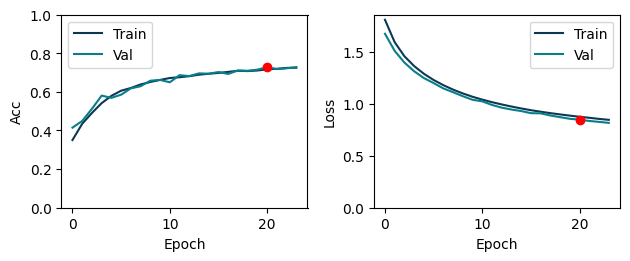

In [78]:
plot_metrics(mlp_reg.history_)

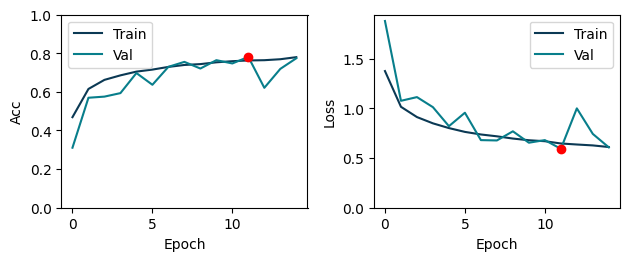

In [142]:
plot_metrics(mlp_best.history_)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
| Class                 | Accuracy | Recall |
---------------------------------------------
| All                   | 0.7612   | 0.7317 |
---------------------------------------------
| basophil              | 0.3566   | 0.3566 |
| eosinophil            | 0.8173   | 0.8173 |
| erythroblast          | 0.6913   | 0.6913 |
| immature granulocytes | 0.4594   | 0.4594 |
| lymphocyte            | 0.7531   | 0.7531 |
| monocyte              | 0.8169   | 0.8169 |
| neutrophil            | 0.9700   | 0.9700 |
| platelet              | 0.9894   | 0.9894 |


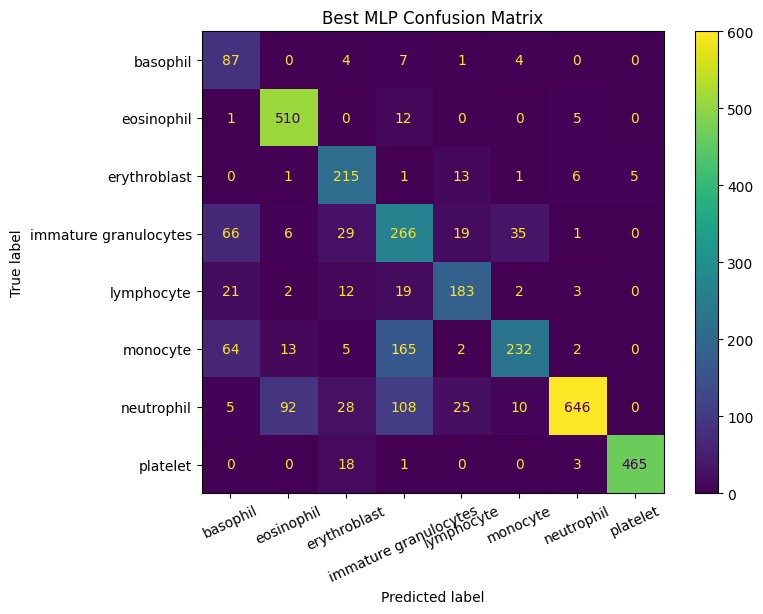

In [147]:
y_pred = mlp_best.predict(X_test)
model_summary(X_test=X_test,
              y_test=y_test,
              y_pred=y_pred,
              labels=labels,
              description="Best MLP",
              filename="mlp_best")

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pt-br

In [20]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=10,
        start_from_epoch=10,
        mode='max',
        restore_best_weights=True
    ),
]

In [21]:
def make_and_train_mlp(options_dict, name=None):
    default_ = {
        'nodes': 100,
        'learning_rate': 1E-3,
        'use_augmentation': False,
        'epochs': 10,
        'batch_size': 32,
        'class_weight': None
    }
    for k,v in default_.items():
        if k not in options_dict:
            options_dict[k] = v
    model = make_mlp(
        nodes=options_dict['nodes'],
        learning_rate=options_dict['learning_rate'],
        use_augmentation=options_dict['use_augmentation'],
        name=name)
    history = model.fit(
        X_train,
        y_train,
        epochs=options_dict['epochs'],
        batch_size=options_dict['batch_size'],
        validation_data = (X_val, y_val),
        class_weight=options_dict['class_weight'],
        callbacks=callbacks)
    return model, history

In [22]:
def save_model(name, model, history=None):
    model.save(f"models/{name}.keras")
    _ = joblib.dump(history, f"models/{name}.hist")

def load_model(name, history=False):
    model = keras.models.load_model(f"models/{name}.keras")
    if history:
        history = joblib.load(f"models/{name}.hist")
        return model, history
    return model


In [23]:
def run_mlp(options, name, force=False):
    if RERUN_MLP or force:
        model, history = make_and_train_mlp(options)

        save_model(name=name,
                   model=model,
                   history=history)
    else:
        model, history = load_model(name=name, history=True)

    return model, history

In [24]:
mlp_models = {}
mlp_history = {}
mlp_options_vanilla = {
    'nodes': 300,
    'learning_rate': 1E-4,
    'use_augmentation': False,
    'epochs': 1000,
    'batch_size': 32,
    'class_weight': None}

model, history = run_mlp(options=mlp_options_vanilla, name="mlp_vanilla", force=True)
mlp_models['Vanilla'] = model
mlp_history['Vanilla'] = history

Epoch 1/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.4151 - loss: 1.5896 - val_acc: 0.6676 - val_loss: 1.0564
Epoch 2/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - acc: 0.6530 - loss: 1.0319 - val_acc: 0.5882 - val_loss: 0.9939
Epoch 3/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.6819 - loss: 0.9196 - val_acc: 0.7208 - val_loss: 0.8148
Epoch 4/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.7195 - loss: 0.8429 - val_acc: 0.7407 - val_loss: 0.7496
Epoch 5/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.7296 - loss: 0.7970 - val_acc: 0.7325 - val_loss: 0.7621
Epoch 6/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.7463 - loss: 0.7583 - val_acc: 0.7593 - val_loss: 0.7116
Epoch 7/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.7510 - loss: 0.7379 - val_acc: 0.7839 - val_loss: 0.6739
Epoch 8/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.7556 - loss: 0.7167 - val_acc: 0.7401 - val_loss: 0.7325
Epoch 9/1000
374/374 ━━━━━━━━━━━

In [25]:
def double_check(model, history):
    x = history.history["val_acc"]
    print(f"Best =  {np.argmax(x)+1}")
    print(f"Total = {len(x)}")

    print(f"Max ACC history = {max(x):0.4f}")
    print(f"Max ACC recalc. = {model.evaluate(X_val, y_val, verbose=0)[1]:0.4f}")

    x = history.history["val_loss"]
    print(f"Min Loss history = {min(x):0.4f}")
    print(f"Min Loss recalc. = {model.evaluate(X_val, y_val, verbose=0)[0]:0.4f}")

In [26]:
double_check(mlp_models['Vanilla'], mlp_history['Vanilla'])

Best =  21
Total = 31
Max ACC history = 0.8405
Max ACC recalc. = 0.8405
Min Loss history = 0.4656
Min Loss recalc. = 0.4978


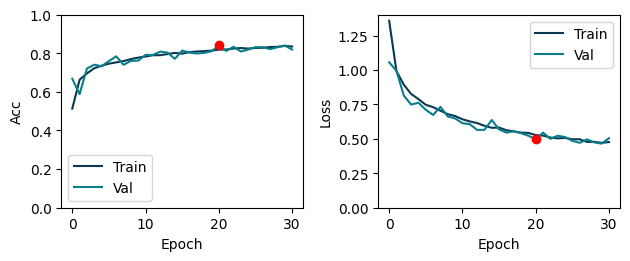

In [31]:
plot_metrics(mlp_history["Vanilla"])

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
| Class                 | Accuracy | Recall |
---------------------------------------------
| All                   | 0.8199   | 0.7889 |
---------------------------------------------
| basophil              | 0.5410   | 0.5410 |
| eosinophil            | 0.9455   | 0.9455 |
| erythroblast          | 0.8135   | 0.8135 |
| immature granulocytes | 0.7306   | 0.7306 |
| lymphocyte            | 0.7695   | 0.7695 |
| monocyte              | 0.6761   | 0.6761 |
| neutrophil            | 0.8453   | 0.8453 |
| platelet              | 0.9894   | 0.9894 |


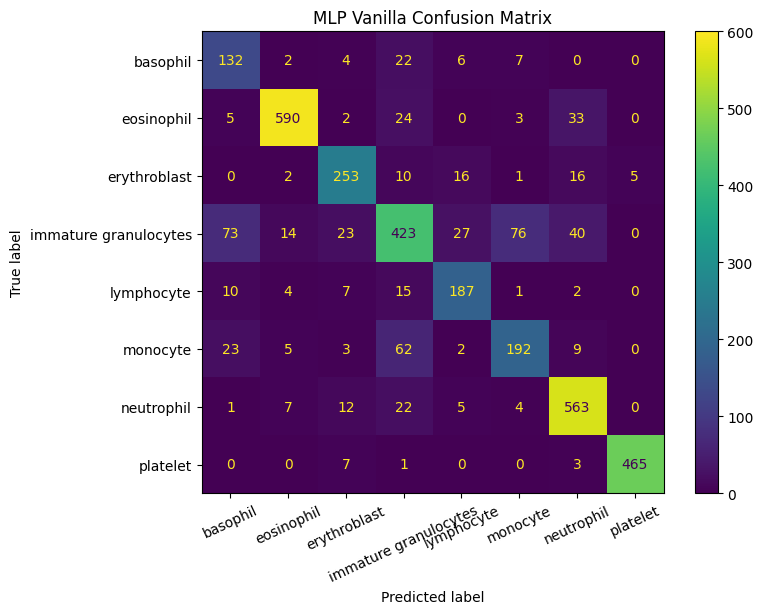

In [116]:
model_summary(mlp_models["Vanilla"], X_test, y_test, labels, "MLP Vanilla", "vanilla_mlp.png")

In [32]:
def update_dict(ref_dict, new_dict):
    updated_dict = ref_dict.copy()
    updated_dict.update({key: value for key, value in new_dict.items() if key in ref_dict})
    return updated_dict

In [34]:
new_options = update_dict(mlp_options_vanilla, {'use_augmentation': True})
model, history = run_mlp(options=new_options, name="mlp_augmentation", force=True)
mlp_models['Augmentation'] = model
mlp_history['Augmentation'] = history

new_options = update_dict(mlp_options_vanilla, {'class_weight': class_weight})
model, history = run_mlp(options=new_options, name="mlp_class_weight", force=True)
mlp_models['Class_weight'] = model
mlp_history['Class_weight'] = history

new_options = update_dict(mlp_options_vanilla, {'use_augmentation': True,'class_weight': class_weight})
model, history = run_mlp(options=new_options, name="mlp_augm_weights", force=True)
mlp_models['Augm_C_weight'] = model
mlp_history['Augm_C_weight'] = history

Epoch 1/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - acc: 0.4095 - loss: 1.6101 - val_acc: 0.4054 - val_loss: 1.4855
Epoch 2/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.5877 - loss: 1.1260 - val_acc: 0.4048 - val_loss: 1.6271
Epoch 3/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - acc: 0.6613 - loss: 0.9913 - val_acc: 0.4357 - val_loss: 1.5153
Epoch 4/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.6688 - loss: 0.9455 - val_acc: 0.5000 - val_loss: 1.3659
Epoch 5/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - acc: 0.6766 - loss: 0.9023 - val_acc: 0.4977 - val_loss: 1.4002
Epoch 6/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.7041 - loss: 0.8551 - val_acc: 0.4971 - val_loss: 1.4650
Epoch 7/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - acc: 0.7154 - loss: 0.8294 - val_acc: 0.5169 - val_loss: 1.3632
Epoch 8/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.7155 - loss: 0.8343 - val_acc: 0.4883 - val_loss: 1.4295
Epoch 9/1000
374/374 ━━━━━━━━━━

In [35]:
for k in mlp_history.keys():
    print(k)
    double_check(mlp_models[k], mlp_history[k])
    print()

Vanilla
Best =  21
Total = 31
Max ACC history = 0.8405
Max ACC recalc. = 0.8405
Min Loss history = 0.4656
Min Loss recalc. = 0.4978

Augmentation
Best =  20
Total = 20
Max ACC history = 0.5964
Max ACC recalc. = 0.5672
Min Loss history = 1.1224
Min Loss recalc. = 1.1541

Class_weight
Best =  19
Total = 20
Max ACC history = 0.8096
Max ACC recalc. = 0.7921
Min Loss history = 0.5504
Min Loss recalc. = 0.6381

Augm_C_weight
Best =  19
Total = 20
Max ACC history = 0.6320
Max ACC recalc. = 0.5450
Min Loss history = 1.0294
Min Loss recalc. = 1.3308



Vanilla
Val acc:  0.8405
Test acc: 0.8164


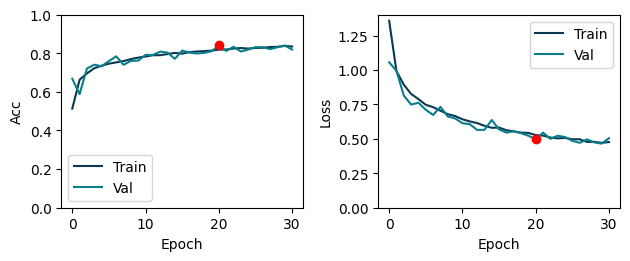

Augmentation
Val acc:  0.5672
Test acc: 0.5647


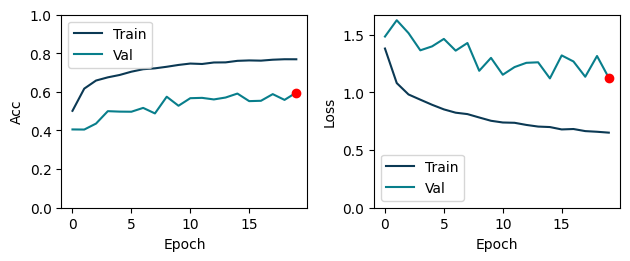

Class_weight
Val acc:  0.7921
Test acc: 0.7758


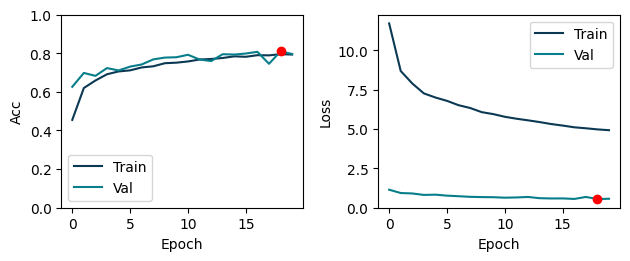

Augm_C_weight
Val acc:  0.5450
Test acc: 0.5291


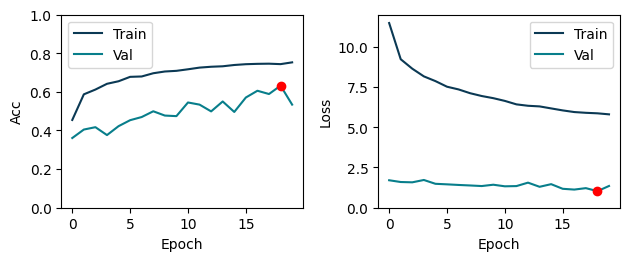

In [36]:
for k,v in mlp_history.items():
    print(k)
    print(f"Val acc:  {mlp_models[k].evaluate(X_val, y_val, verbose=0)[1]:0.4f}")
    print(f"Test acc: {mlp_models[k].evaluate(X_test, y_test, verbose=0)[1]:0.4f}")
    plot_metrics(v)
    plt.show()

In [ ]:
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)


## Simple CNN

## Deep CNN